이미지 로드 및 전처리

In [13]:
import cv2

# 이미지 로드 (회색조로)
image = cv2.imread('C:/Users/chaerim/OneDrive/Calibration/matching/cam1_cam2_2degree_split_c/left/img_1_00018.jpg', cv2.IMREAD_GRAYSCALE)


웨이블릿 변환을 사용하여 가장자리 추출

In [11]:
from pywt import wavedec2, waverec2
import numpy as np


# 웨이블릿 변환 수행
coeffs = wavedec2(image, 'sym10', level=3)
coeffs[0] = np.zeros_like(coeffs[0])  # LL 서브밴드 제거
edges_wt = waverec2(coeffs, 'sym10')

# 결과 시각화
cv2.imshow('Wavelet Transform Edges', edges_wt)
cv2.waitKey(0)
cv2.destroyAllWindows()


가우시안 차이 (DoG) 사용하여 가장자리 추출

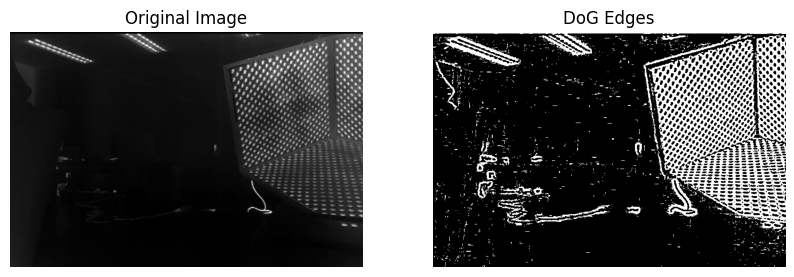

In [14]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# 두 개의 가우시안 필터 적용
image_blurred1 = gaussian_filter(image, sigma=1)
image_blurred2 = gaussian_filter(image, sigma=2)
edges_dog = image_blurred1 - image_blurred2

# Otsu 임계값 적용하여 이진 마스크 생성
_, binary_mask = cv2.threshold(edges_dog, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# DoG 결과 시각화 (Matplotlib)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('DoG Edges')
plt.axis('off')

# DoG 가장자리 이미지 저장
plt.imsave('dog_edges_L18.png', binary_mask, cmap='gray')

plt.show()

In [11]:
import cv2
import numpy as np
import pywt
from skimage.filters import threshold_otsu

def dog_filter(image, ksize1=5, ksize2=9):
    """
    Apply Difference of Gaussian (DoG) filter to an image.
    """
    blur1 = cv2.GaussianBlur(image, (ksize1, ksize1), 0)
    blur2 = cv2.GaussianBlur(image, (ksize2, ksize2), 0)
    dog = blur1 - blur2
    return dog

def dwt_filter(image, wavelet='db1'):
    """
    Apply 2D Discrete Wavelet Transform (DWT) to an image and reconstruct the image.
    """
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2
    reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), wavelet)
    return reconstructed_image

def generate_otsu_mask(image):
    """
    Generate a binary mask using Otsu's thresholding method.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Apply Otsu's thresholding
    otsu_threshold = threshold_otsu(gray_image)
    binary_mask = gray_image > otsu_threshold
    
    return binary_mask.astype(np.uint8)

# Load your image
image_path = 'cam1_cam2_2degree_split_c/left/img_1_00027.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply DoG filter
dog_image = dog_filter(image)

# Apply DWT filter
dwt_image = dwt_filter(image)

# Generate Otsu masks
dog_otsu_mask = generate_otsu_mask(dog_image)
dwt_otsu_mask = generate_otsu_mask(dwt_image)

# Save or display the results
cv2.imwrite('dog_image.jpg', dog_image)
cv2.imwrite('dwt_image.jpg', dwt_image)
cv2.imwrite('dog_otsu_mask.jpg', dog_otsu_mask * 255)  # Save binary mask as an image
cv2.imwrite('dwt_otsu_mask.jpg', dwt_otsu_mask * 255)  # Save binary mask as an image

# Optional: Display the results using OpenCV (remove if running in a non-interactive environment)
cv2.imshow('Original Image', image)
cv2.imshow('DoG Image', dog_image)
cv2.imshow('DWT Image', dwt_image)
cv2.imshow('DoG Otsu Mask', dog_otsu_mask * 255)
cv2.imshow('DWT Otsu Mask', dwt_otsu_mask * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
import cv2
import numpy as np
import pywt
from skimage.filters import threshold_otsu

def dwt_filter(image, wavelet='db1'):
    """
    Apply 2D Discrete Wavelet Transform (DWT) to an image and reconstruct the image.
    """
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2
    reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), wavelet)
    return reconstructed_image

def generate_otsu_mask(image):
    """
    Generate a binary mask using Otsu's thresholding method.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Apply Otsu's thresholding
    otsu_threshold = threshold_otsu(gray_image)
    binary_mask = gray_image > otsu_threshold
    
    return binary_mask.astype(np.uint8)

def detect_circles(image):
    """
    Detect circles in the image using Hough Circle Transform.
    """
    # Convert to uint8
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(image_uint8, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=1, maxRadius=30)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
    
    return circles

# Load your image
image_path = 'cam1_cam2_2degree_split_c/left/img_1_00027.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded properly
if image is None:
    print("Error: Could not load image. Check the image path.")
else:
    # Apply DWT filter
    dwt_image = dwt_filter(image)

    # Generate Otsu mask
    dwt_otsu_mask = generate_otsu_mask(dwt_image)
    
    # Detect circles in the DWT Otsu mask image
    circles_dwt = detect_circles(dwt_otsu_mask * 255)

    # Function to draw circles on the image
    def draw_circles(image, circles):
        if circles is not None:
            for (x, y, r) in circles:
                cv2.circle(image, (x, y), r, (0, 255, 0), 4)
                cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return image

    # Draw circles on the images
    output_dwt_otsu = cv2.cvtColor(dwt_otsu_mask * 255, cv2.COLOR_GRAY2BGR)
    output_dwt_otsu = draw_circles(output_dwt_otsu, circles_dwt)

    # Save or display the results
    cv2.imwrite('output_dwt_otsu.jpg', output_dwt_otsu)

    # Optional: Display the results using OpenCV (remove if running in a non-interactive environment)
    cv2.imshow('DWT Otsu Mask with Circles', output_dwt_otsu)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [14]:
import cv2
import numpy as np
import pywt
from skimage.filters import threshold_otsu

def dwt_filter(image, wavelet='db1'):
    """
    Apply 2D Discrete Wavelet Transform (DWT) to an image and reconstruct the image.
    """
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2
    reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), wavelet)
    return reconstructed_image

def generate_otsu_mask(image):
    """
    Generate a binary mask using Otsu's thresholding method.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Apply Otsu's thresholding
    otsu_threshold = threshold_otsu(gray_image)
    binary_mask = gray_image > otsu_threshold
    
    return binary_mask.astype(np.uint8)

def fct_detect_circles(image, min_radius, max_radius):
    """
    Detect circles using a Fast Circle Transform-like approach.
    """
    rows, cols = image.shape
    accumulator = np.zeros((rows, cols, max_radius - min_radius + 1), dtype=np.uint8)
    
    edges = cv2.Canny(image, 50, 150)
    
    for y in range(rows):
        for x in range(cols):
            if edges[y, x] > 0:
                for r in range(min_radius, max_radius + 1):
                    for theta in range(0, 360, 5):
                        a = int(x - r * np.cos(np.deg2rad(theta)))
                        b = int(y - r * np.sin(np.deg2rad(theta)))
                        if 0 <= a < cols and 0 <= b < rows:
                            accumulator[b, a, r - min_radius] += 1

    circles = []
    threshold = 100
    for r in range(max_radius - min_radius + 1):
        acc_slice = accumulator[:, :, r]
        acc_slice = cv2.GaussianBlur(acc_slice, (5, 5), 2)
        centers = np.where(acc_slice > threshold)
        for center in zip(centers[1], centers[0]):
            circles.append((center[0], center[1], r + min_radius))
    
    return circles

# Load your image
image_path = 'cam1_cam2_2degree_split_c/left/img_1_00027.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded properly
if image is None:
    print("Error: Could not load image. Check the image path.")
else:
    # Apply DWT filter
    dwt_image = dwt_filter(image)

    # Generate Otsu mask
    dwt_otsu_mask = generate_otsu_mask(dwt_image)
    
    # Detect circles in the DWT Otsu mask image using FCT
    circles_dwt = fct_detect_circles(dwt_otsu_mask * 255, min_radius=10, max_radius=30)

    # Function to draw circles on the image
    def draw_circles(image, circles):
        if circles is not None:
            for (x, y, r) in circles:
                cv2.circle(image, (x, y), r, (0, 255, 0), 4)
                cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return image

    # Draw circles on the images
    output_dwt_otsu = cv2.cvtColor(dwt_otsu_mask * 255, cv2.COLOR_GRAY2BGR)
    output_dwt_otsu = draw_circles(output_dwt_otsu, circles_dwt)

    # Save or display the results
    cv2.imwrite('output_dwt_otsu.jpg', output_dwt_otsu)

    # Optional: Display the results using OpenCV (remove if running in a non-interactive environment)
    cv2.imshow('DWT Otsu Mask with Circles', output_dwt_otsu)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


허프 변환을 사용하여 원 탐지

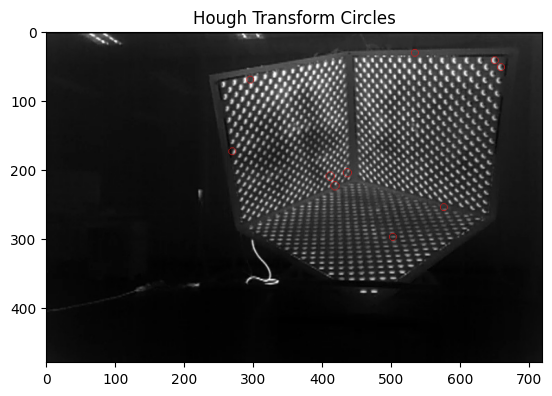

In [4]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter

# 캐니 에지 검출기를 적용
edges = feature.canny(binary_mask)

# 허프 변환을 사용하여 원 탐지
hough_radii = np.arange(5, 30, 1)
hough_res = transform.hough_circle(edges, hough_radii)

# 원 탐지 결과에서 상위 원 선택
accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)

# 원을 원본 이미지에 그리기
image_with_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image_with_circles[circy, circx] = (220, 20, 20)  # 빨간색으로 원 표시

# 결과 시각화
plt.imshow(image_with_circles)
plt.title('Hough Transform Circles')
plt.show()


빠른 원형 변환(FCT)을 사용하여 원 탐지

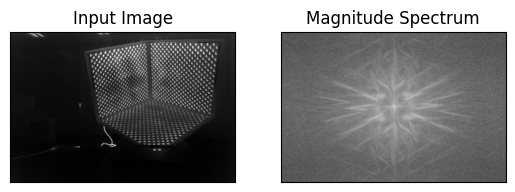

In [5]:
# FCT 변환은 고급 주파수 도메인 변환을 필요로 합니다.
# 여기서는 대체 방법으로 간단히 FFT를 적용해봅니다.

def detect_circles_fft(image):
    # FFT를 적용하여 주파수 도메인으로 변환
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # 주파수 스펙트럼 시각화
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

# 함수 호출
detect_circles_fft(image)


잘못된 원 제거 및 후처리

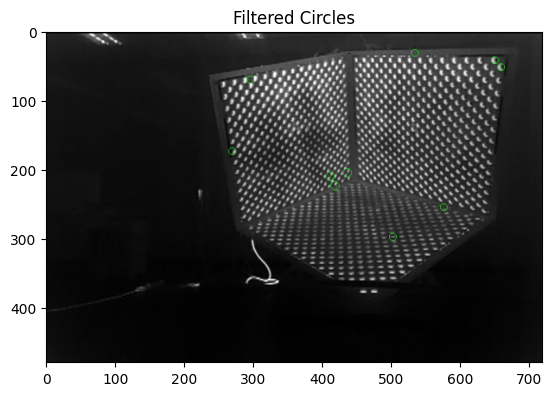

In [6]:
# 탐지된 원들 중에서 잘못된 원 제거
# 예를 들어, 원의 중심이 너무 가깝거나 겹치는 경우 제거

def remove_false_circles(circles, min_distance=10):
    filtered_circles = []
    for circle in circles:
        if all(np.linalg.norm(np.array(circle[:2]) - np.array(other[:2])) > min_distance for other in filtered_circles):
            filtered_circles.append(circle)
    return filtered_circles

# 잘못된 원 제거 후 남은 원들
filtered_circles = remove_false_circles(zip(cy, cx, radii))

# 결과 시각화
image_filtered_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for center_y, center_x, radius in filtered_circles:
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image_filtered_circles[circy, circx] = (20, 220, 20)  # 초록색으로 원 표시

plt.imshow(image_filtered_circles)
plt.title('Filtered Circles')
plt.show()


In [7]:
# 예를 들어, ground_truth_mask가 있다면 다음과 같이 평가 지표를 계산합니다.
# ground_truth_mask는 정답 마스크입니다.

def calculate_metrics(detected_mask, ground_truth_mask):
    intersection = np.logical_and(detected_mask, ground_truth_mask)
    union = np.logical_or(detected_mask, ground_truth_mask)
    
    # 면적 비율 (AR)
    ar = np.sum(detected_mask) / np.sum(ground_truth_mask)
    
    # 다이스 유사성 계수 (DSC)
    dsc = 2 * np.sum(intersection) / (np.sum(detected_mask) + np.sum(ground_truth_mask))
    
    # 전체 차별화 지수 (ODF)
    odf = ar * dsc
    
    return ar, dsc, odf

# 예시: ground_truth_mask를 임의로 생성
ground_truth_mask = np.zeros_like(image, dtype=bool)
ground_truth_mask[100:200, 100:200] = 1  # 임의의 정답 영역

# detected_mask는 이진 마스크로, 필터링된 원들을 포함합니다.
detected_mask = np.zeros_like(image, dtype=bool)
for center_y, center_x, radius in filtered_circles:
    circy, circx = circle_perimeter(center_y, center_x, radius)
    detected_mask[circy, circx] = 1

# 평가 지표 계산
ar, dsc, odf = calculate_metrics(detected_mask, ground_truth_mask)
print(f'Area Ratio (AR): {ar}, Dice Similarity Coefficient (DSC): {dsc}, Overall Discrimination Factor (ODF): {odf}')


Area Ratio (AR): 0.0292, Dice Similarity Coefficient (DSC): 0.0, Overall Discrimination Factor (ODF): 0.0
